C:\Users\jonas\AppData\Local\Temp\ipykernel_6004\3569922477.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


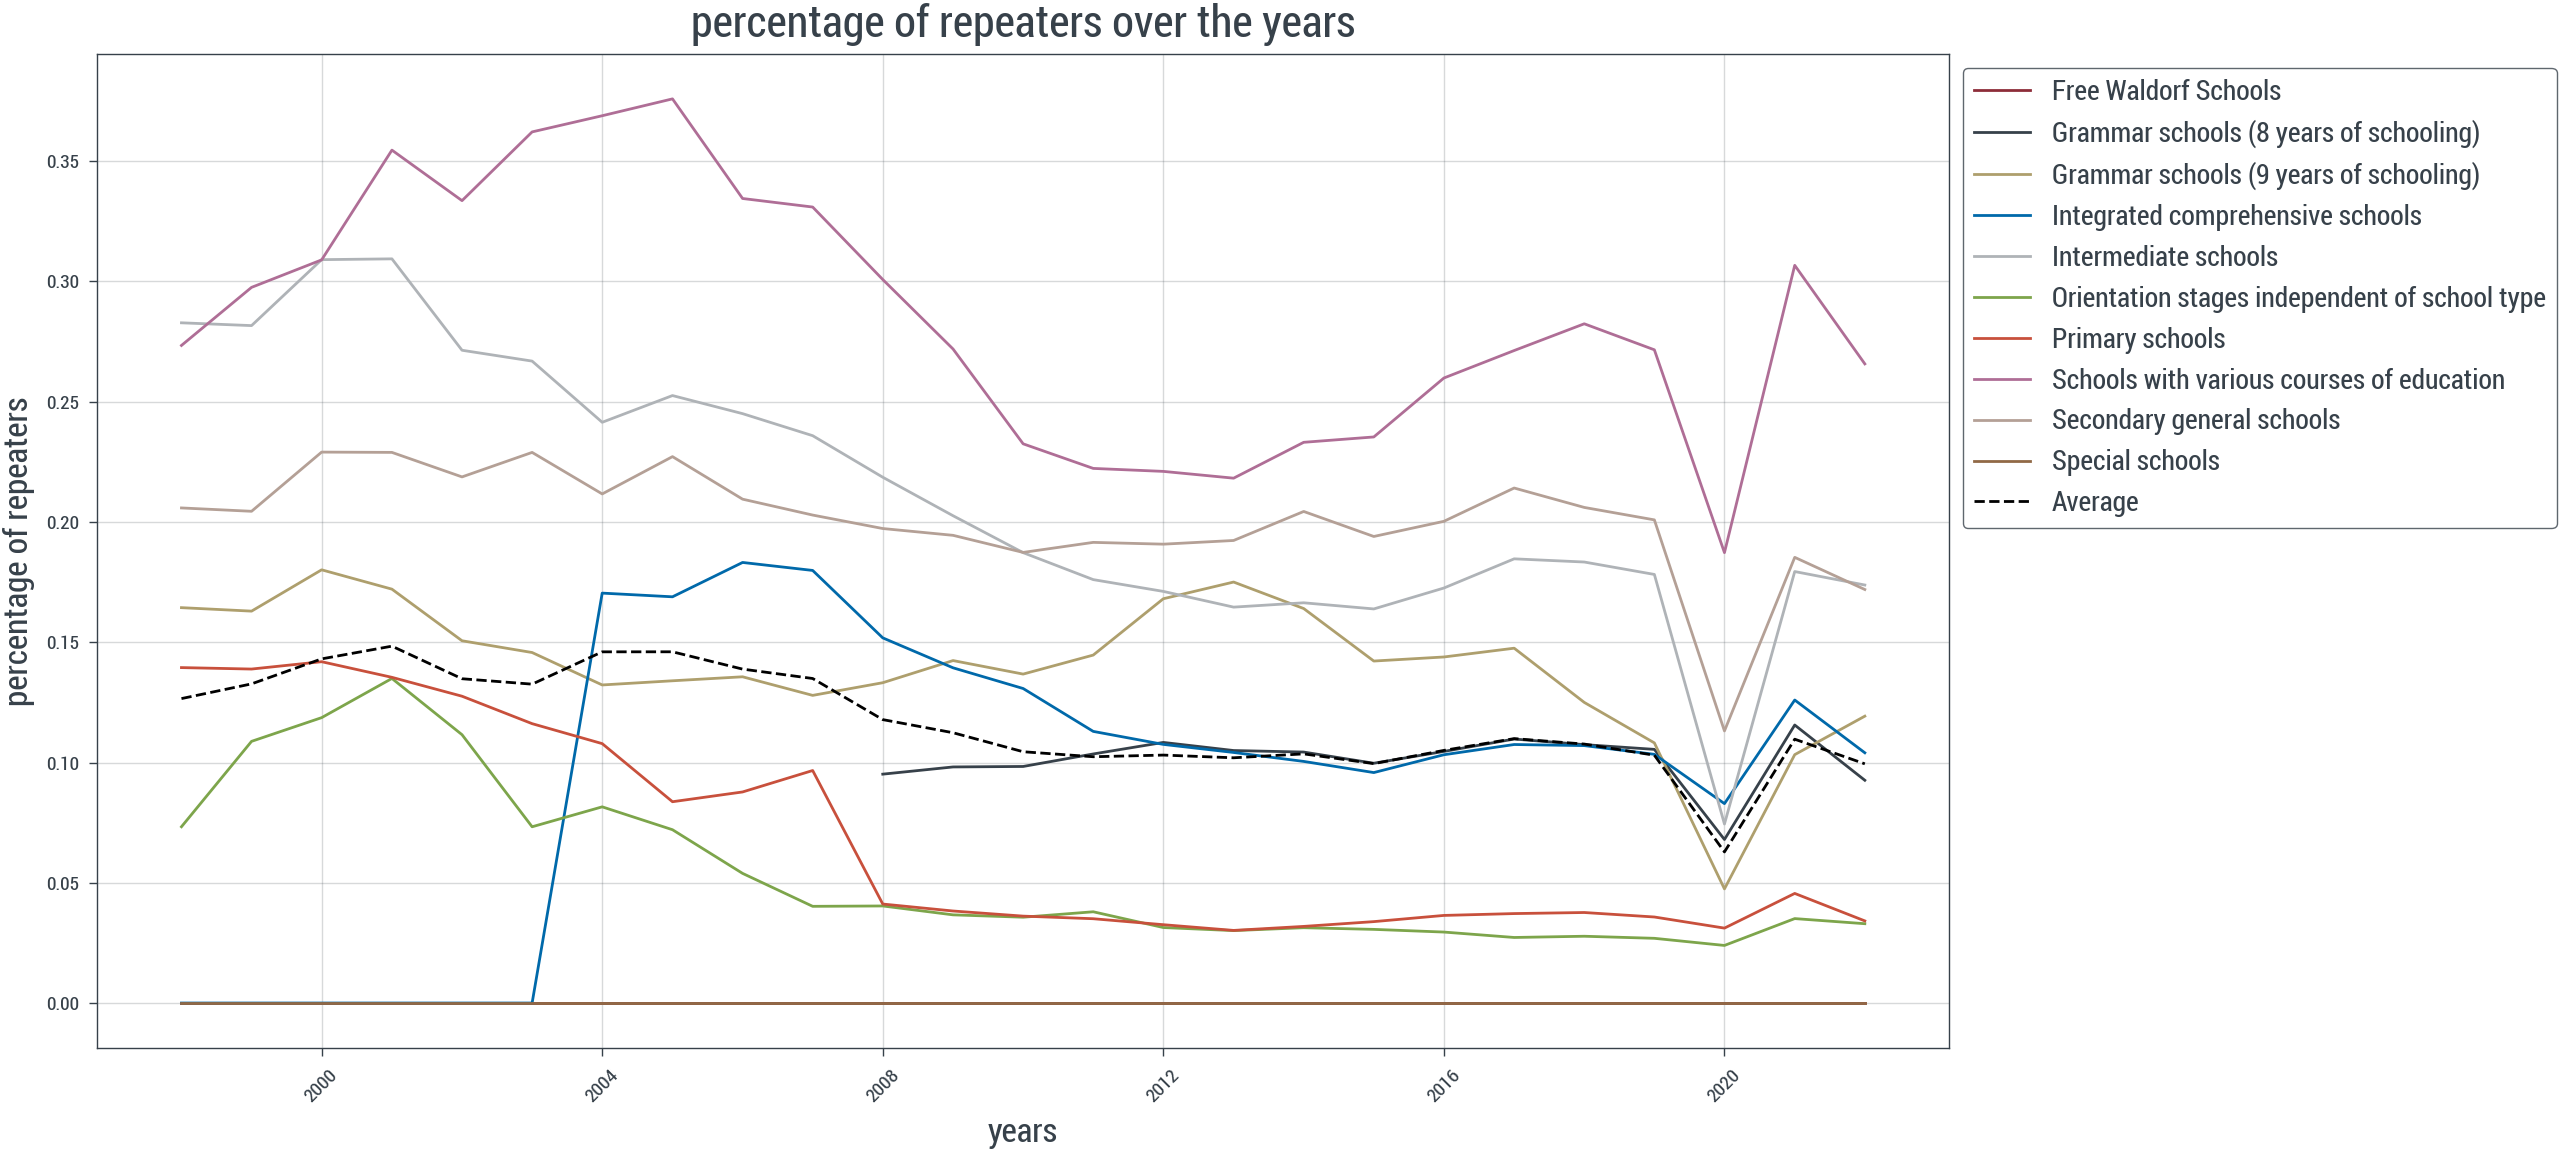

In [12]:
from school_analysis.preprocessing.load import Loader
import pandas as pd


loader = Loader()
melted_df = loader.load('number_of_repeaters')


melted_df['year'] = pd.to_datetime(melted_df['year'], format='%Y')
melted_df['total'] = pd.to_numeric(melted_df['total'], errors='coerce')
total_over_years = melted_df.groupby(['year','school'])['total'].sum()

children_state = loader.load('school-children-by-type')
children_state = children_state.rename(columns={'Year': 'year'})
children_state = children_state.rename(columns={'School Type': 'school'})
children_state['year'] = pd.to_datetime(children_state['year'], format='%Y')
child_amount_per_year = children_state.groupby(['year','school'])['Students'].sum()

df_repeaters = pd.merge(total_over_years, child_amount_per_year, on=['year','school'])
df_repeaters['relative'] = df_repeaters['total']/df_repeaters['Students'] 
df_repeaters


import matplotlib.pyplot as plt
import seaborn as sns

average_per_year = df_repeaters.groupby('year')['relative'].mean().reset_index()

# Setzen des Plots
plt.figure(figsize=(10, 6))

# Erstellen eines Plots für jede Schule
sns.lineplot(data=df_repeaters, x='year', y='relative', hue='school')
sns.lineplot(data=average_per_year, x='year', y='relative', color='black', linestyle='--', label='Average')


plt.title('percentage of repeaters over the years', fontsize=16)
plt.xlabel('years', fontsize=12)
plt.ylabel('percentage of repeaters', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.show()
